### Intorduction

This tutorial will introduce you some basic methods for processing audio signal, particularly focusing on Music Information Retrieval (MIR). MIR is basically computation tasks that simulates the human understanding of music. Echo nest has a world's only "music listening" public API called **[Analyzer](http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf)**, which can generate acoustic feature of the song for you. But this tutorial will use another MIR library - **[madmom](https://github.com/CPJKU/madmom)** to demostrate how to extract the information directly from audio contents (e.g. time signature, chord, beat per second, etc.) and to visualize it. These information are often useful for music discovery, recommandation as a counterpart of text information (e.g. the purchase history, social network data.) If you are interested in how music streaming service, such as Spotify, Amazon Music and Pandora, recommends songs to you, [here](http://notes.variogr.am/post/37675885491/how-music-recommendation-works-and-doesnt-work) is a great article. 

A typical example would look like this, a song "rich chigga" downloaded from youtube:

![](./figure.png)

In [19]:
FILEPATH = "https://github.com/cheyuanl/Data-Science_Tutorial/raw/master/richchigga.wav"

In [ ]:
import IPython.display
audio = IPython.display.Audio(FILEPATH)
IPython.display.display(audio)

### Tutorial Content
This tutorial will go through the process from an raw audio file to higher-level representations step by step using the **madmom** library. I will demostrate some possible applications for using these extracted information.

* [Installing the libraries](#Installing-the-libraries)
* [Basic Data processing](#Basic-Data-Processing)
* [Example : Onset activation extraction - how intense is a music?](#Example:-Onset-activation-extraction)
* [Example : Beat extraction - what is the pace of a music?](#Example-:-Beat-extraction---computing-Beat-Per-Minutes)
* [Example: Pitch extraction - what is the mood of music?](#Example-Note-Extraction)
* [Example : Chord extraction - simple guitar hero](#Example:-Chord-extraction) 



### Installing the libraries
A comprehensive installation instruction could be find [here](https://madmom.readthedocs.io/en/latest/installation.html). 
In short, you need to have Python2.7 or Python3.4 and the following packages in your computer:

* [numpy](http://www.numpy.org)
* [scipy](http://www.scipy.org)
* [cython](http://cython.org)
* [nose](https://github.com/nose-devs/nose) (to run the tests)

If your are using mac just type in the following in the terminal:
    
~~~~
$ pip install madmom
~~~~

It's all set!


### Basic Data Processing
A comprehensive tutorial on signal handling can be find [here](https://github.com/CPJKU/madmom_tutorials/blob/master/audio_signal_handling.ipynb). I will go through the basic data processing without assumption on prior knowledge in digital signal processing.

#### Load audio file
Audio file is basically just an 1-D sequence of samples. Basically what we need to do here is to load the samples in to the memory, which can be done in one line. We can see the signal is just a sequence of value, and the *sample rate* is just time interval between the each sample.


In [3]:
import madmom
signal, sample_rate = madmom.audio.signal.load_wave_file(FILEPATH)

print 'Signal : {}'.format(signal) + ' ({})'.format(type(signal)) + ' shape: {}'.format(signal.shape) 
print 'Sample rate: {}'.format(sample_rate)

Signal : [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]] (<class 'numpy.core.memmap.memmap'>) shape: (5677056, 2)
Sample rate: 44100


/usr/local/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


As you can see the signal is actually an 2-D array. This is because the audio file is stereo. Since it looks like currently the library only support mono audio file in some function. For simplicity, I will convert all input file to be mono by adding an argument.

In [4]:
signal, sample_rate = madmom.audio.signal.load_wave_file(FILEPATH, num_channels=1) # convert to mono

print 'Signal : {}'.format(signal) + ' ({})'.format(type(signal)) + ' shape: {}'.format(signal.shape) 

Signal : [ 0.  0.  0. ...,  0.  0.  0.] (<class 'numpy.core.memmap.memmap'>) shape: (5677056,)


#### Magnitude Spectrogram

The magitute spectrogram is one the most common representation for audio signal. It is also much similar to what we percieved in our hearing (and also much readable, and we will see the figure soon). It takes three lines to convert an audio file to magnitude spectrogram representation in madmom library. We have to first load the signal into the **framed signal**, which is basically chopping the sample sequences into chunks, where each chunks are overlapped, in order to compute the short-time fourier transform. (in order to the extract the frequency components of the audio signal.)

In [5]:
framedSignal = madmom.audio.signal.FramedSignal(FILEPATH, num_channels=1) # choping samples into overlapped chunks
stft = madmom.audio.stft.STFT(framedSignal) # short-time-fourier transform
magSpecgram = madmom.audio.spectrogram.Spectrogram(stft) # magnitude spectrogram

Now we can visualize the magnitude spectrogram, which makes much more sense visually. We cam see the brightness and color are corresponding to the magnitude, the frequency bins on the y-axis are coressponding to the frequecny component we hear, and the x-axis is the time.

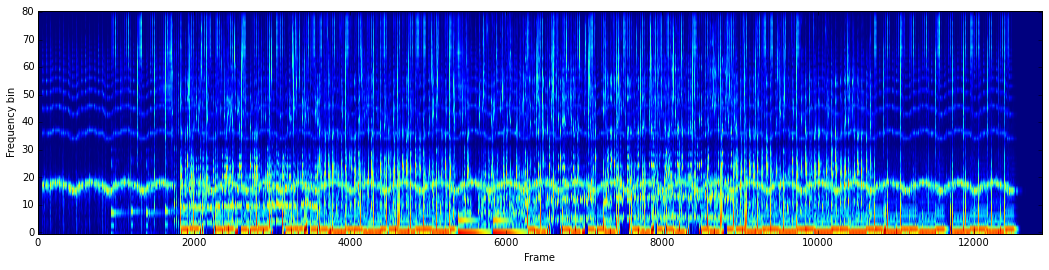

In [6]:
%matplotlib inline
import matplotlib.pylab
import matplotlib.pyplot as plt
matplotlib.pylab.rcParams['figure.figsize'] = (18, 4)

logMagSpecgram = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(stft) # logfilt for better visualization
plt.imshow(logMagSpecgram[:, :200].T, aspect='auto', origin='lower') # plot the spectrogram 
plt.xlabel('Frame')
plt.ylabel('Frequency bin')

Using this represntation, we can clearly see there is a comb-like sound at the lower part of the spectrogram, which is the bass component that is repeating through out the song. 

Note that there are a lot of variations of "spectrogram", such as "LogarithmicFilteredSpectrogram" as you will see later, but basically they are just different features representation as the input of algorithm.

### Example: Onset activation extraction

Onset is a relative low-level represntation in music. It is basically just an indicator of whether there is any note "activated", which can be ploted along the time axis. [Here](https://github.com/CPJKU/madmom_tutorials/blob/master/onset_detection.ipynb) is a comprehensive tutorial of onset extraction using the library. I will go through the basics using few lines of codes to demostrate how to extract the onsets from the audio signal.

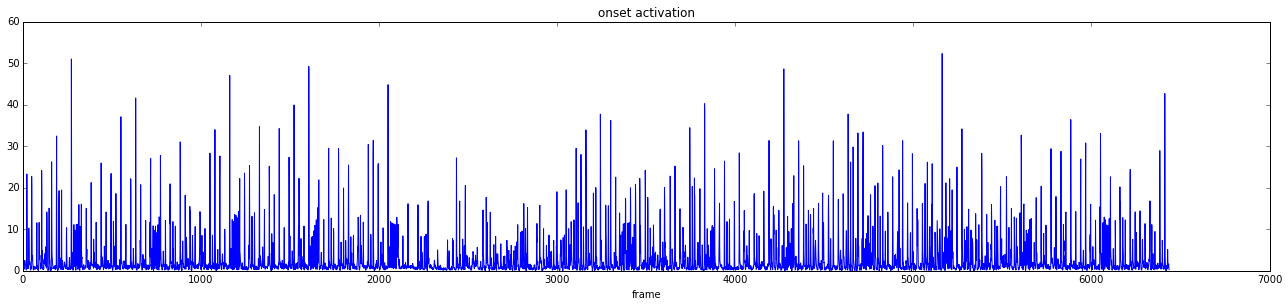

In [7]:
# First compute the audio into log-filt-spectrogram
log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(FILEPATH, num_bands=24, num_channels = 1) 
onset = madmom.features.onsets.superflux(log_filt_spec) # SuperFlux is the name of the onset extractor

plt.plot(onset[len(onset)/4:-len(onset)/4])
plt.tight_layout()
plt.title('onset activation')
plt.xlabel('frame')

####  Application (How intense is the audio?):
So what can we interpret from the onset activation feature? For example, we can define the feature called **onset density** of an audio file (or a range of audio clip) to give us some sense about how intense it is.

In [8]:
# Sum up the intensity of onset activation function
def onsetDensity(FILEPATH):
    signal, sample_rate = madmom.audio.signal.load_wave_file(FILEPATH, num_channels = 1)
    duration = len(signal) / float(sample_rate) # duration = samples / sample_rate (sample_rate = sample / time)
    print "Duration: {} seconds".format(duration)
    
    log_filt_spec = \
    madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(FILEPATH,\
                num_bands=24, num_channels = 1, norm_filters = True) # Normalizing the magnitudes
    onset = madmom.features.onsets.superflux(log_filt_spec)
    sumActivation = sum(onset)
    print "Intensity : {}".format(sumActivation)
    
    return sumActivation / duration

onsetDensity = onsetDensity(FILEPATH)

print 'Onset Density : {} unit / sec'.format(onsetDensity)
    

Duration: 128.731428571 seconds
Intensity : 31716.1865165
Onset Density : 246.37485087 unit / sec


### Example : Beat extraction - estimate beat per minutes

The beat is the time when people will naturally tap their foot. BPM is an useful attribute that indicates how fast is the music, which is a slightly higher level of representation comparing to onset (i.e. not trivially transform from the raw audio signal.) For example, people has been using neural network with extensive training data for this task [here](http://recherche.ircam.fr/pub/dafx11/Papers/31_e.pdf), yet it couldn't achieve the robustness of human. However, it is still useful to indecate the pace of the music, like there are some playlists on online streaming services that are sorted by BPM. To calculate the beat per minues, we have to first calculate the beat activation as a time series.

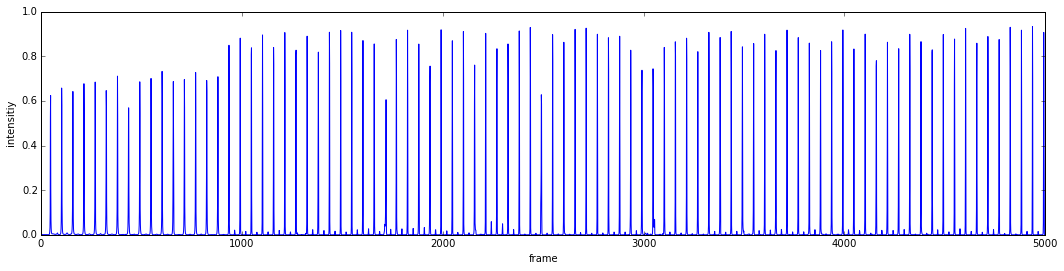

In [9]:
from madmom.features import RNNBeatProcessor

proc = madmom.features.tempo.TempoEstimationProcessor(fps=100)
act = RNNBeatProcessor()(FILEPATH)
plt.plot(act[0:5000]) 
plt.xlabel("frame")
plt.ylabel("intensitiy")

#### Application (how fast is the music):

As you can see, the beat is a steady activation with almost equal-spaced intervals in time, as opposed to onset activation which is not equally spaced. These peaks indicate when people will natrally tap their foot. From this time series, we can compute the beats(peak) per minutes by simply computing how many beats were in the range. For this demo, I will assume the peak to be the value that is higher than the threshold for simplicity.

In [10]:
def computeBPM(act):
    FPS = 100 # Assume there are 100 frames(sample) per second (fps = 100 was defined in beat processor above)
    THRESHOLD = 0.4
    peaks = [(b,t) for b, t in zip(act, range(len(act))) if b >= THRESHOLD] 
    
    # Remove the duplicates since the there are multiple "b"s are counted using the above naive computation. 
    # Assume there is no two beats happends within the interval of 0.1 seconds. We can first quantize the time
    # instances of beats, and remove the the duplicates.
    t = [t for b, t in peaks]
    
    # INTERVAL 0.1s = 0.1 * 100(sample rate) = 10 samples
    INTERVAL = 10
    quantized_t = map(lambda x : x / INTERVAL, t)    
    bps = len(set(quantized_t)) / (float(len(act)) / FPS) ## beats per second
    bpm = bps * 60
    
    return bpm
    
computeBPM(act)

108.59095852105017

### Example Pitch Extraction
A note can roughly be decribe by three attributes: 1. the pitch (i.e. 440 hz), 2. the starting time and 3. the duration (i.e. 0.5 second). And a list of note can describe most of the music. So far we haven't cover about the frequency (pitch) aspect of the music, we only covered the atrributes in time (onset, beat).

The pitch/freqency/key can be use interchangeblely, and there is a direct mapping from the frequency to the key on the keyboard, where each key has a correspondent frequency. A piano roll representation (as shown below) can visualize the map between frequencies to the keys to the piano. Since there are 88 keys on the piano, we can see there are 88 bins on the y-axis. There detail mapping relationship can be found [here](https://en.wikipedia.org/wiki/Piano_key_frequencies).


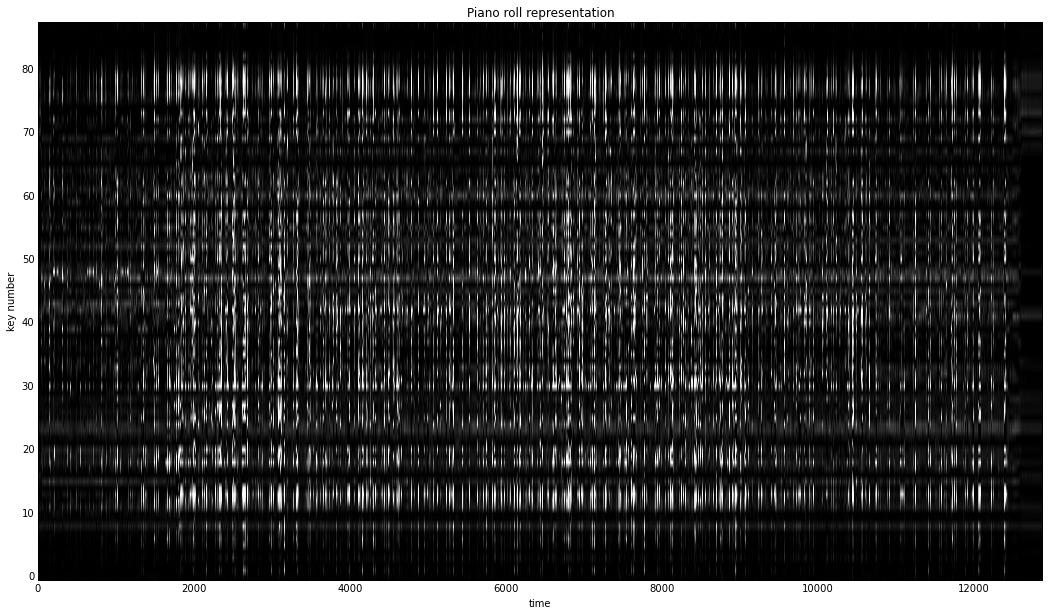

In [11]:
import numpy as np
proc = madmom.features.notes.RNNPianoNoteProcessor()
act = proc(FILEPATH)
matplotlib.pylab.rcParams['figure.figsize'] = (18, 10)
plt.imshow(np.clip(act.T, 0, 0.01), aspect='auto', origin='lower', cmap='Greys_r') # clip the value for clarity 
plt.xlabel('time')
plt.ylabel('key number')
plt.title('Piano roll representation')

####  Application (The mood of the music):

What can we interpret from this representation? One application is that we can somehow infer the **scale** of the music.
For example, whether a piece of music is in major (happy) scale or minor (sad) scale. In the simple demostration, I will compute the distribution of note just like how we compute the bag-of-word (key), we can further infer the scale of the music by computing the distribution of these pitches. For example:

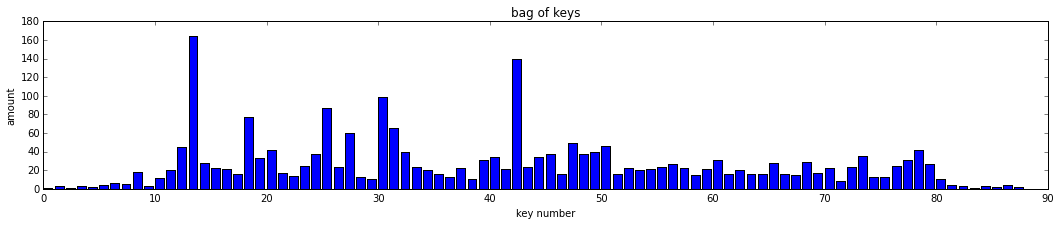

In [12]:
matplotlib.pylab.rcParams['figure.figsize'] = (18, 3)

def bagOfKeys(act):
    result = np.abs(act).sum(axis = 0)
    return result
    
bk = bagOfKeys(act)
plt.bar(range(88), bk)
plt.title('bag of keys')
plt.xlabel('key number')
plt.ylabel('amount')

Furthermore, there is a more compact representation called [chroma](https://en.wikipedia.org/wiki/Chroma_feature) feature, which is just a modulate version of the "bag of key" to 12 bins in x-axis. Because every 12 bins of frequency interval is an octave in the musical sense, meaning they are actually the similar to human. For example, we can see from the above figure that the correlation between octave distant bins are high. Therfore, we can basically un-roll 88 keys in into 12 bins (i.e. 88 % 12 ). For example:

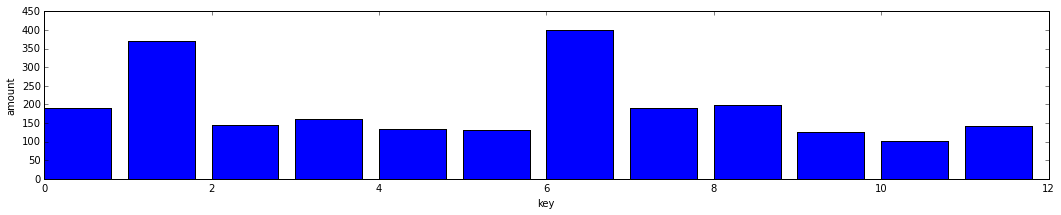

In [13]:
matplotlib.pylab.rcParams['figure.figsize'] = (18, 3)
def bkToChroma(bk):
    result = [0] * 12
    for i in xrange(len(bk)):
        result[i % 12] += bk[i]
    return result

chroma = bkToChroma(bk)

plt.bar(range(12), chroma)
plt.xlabel('key')
plt.ylabel('amount')

From this bag-of-chroma feature, we can easily see this piece of music is in key[6] as the root, since it has the most prominant peak. Furthermore, if we send this distribution into the classifier with several training data, we can easily get if this song in major scale or minor scale.

### Example: Chord extraction

The chord is composed of with different pitches at the same time, like struming the strings on guitar. [Here](http://chordbook.com/guitar-chords/) is a great example of what is chord. In this level of representation, we can almost discribe the whole song by using merely a sequence of chord progression symbol. 
For example: 
```
F C7 
Happy Birthday to you 
(C7) F 
Happy Birthday to you 
F Bb (melody: E natural to D) 
Happy Birthday dear friend 
F/C C7 F 
Happy Birthday to you! 
```
(you could try the chord progression using the link above)

This can also be done in few lines of code as follows:

In [15]:
from madmom.audio.chroma import DeepChromaProcessor # Instead of compute the chroma ourself, madmom handle this for us.
from madmom.features import DeepChromaChordRecognitionProcessor # The algorithm that transform the 
                                                                # chroma time series to chord time series.
dcp = DeepChromaProcessor() 
chroma = dcp(FILEPATH) 

decode = DeepChromaChordRecognitionProcessor()
chords = decode(chroma) # decode the output to be human readible symbol (i.e. c#:maj)

chords

array([(0.0, 21.900000000000002, u'N'),
       (21.900000000000002, 25.700000000000003, u'B:maj'),
       (25.700000000000003, 28.3, u'G#:min'),
       (28.3, 38.900000000000006, u'N'),
       (38.900000000000006, 46.400000000000006, u'C#:maj'),
       (46.400000000000006, 47.400000000000006, u'N'),
       (47.400000000000006, 49.2, u'G#:maj'),
       (49.2, 50.800000000000004, u'C#:maj'),
       (50.800000000000004, 53.7, u'N'), (53.7, 55.5, u'F#:maj'),
       (55.5, 56.6, u'F#:min'), (56.6, 58.5, u'G#:maj'),
       (58.5, 63.800000000000004, u'C#:maj'),
       (63.800000000000004, 65.5, u'D#:maj'), (65.5, 71.7, u'N'),
       (71.7, 72.8, u'C#:maj'), (72.8, 73.9, u'G#:maj'),
       (73.9, 76.4, u'D#:maj'), (76.4, 80.7, u'G#:maj'),
       (80.7, 84.7, u'E:maj'), (84.7, 87.10000000000001, u'N'),
       (87.10000000000001, 88.2, u'E:maj'),
       (88.2, 89.60000000000001, u'G#:maj'),
       (89.60000000000001, 90.80000000000001, u'C#:maj'),
       (90.80000000000001, 91.9, u'N'), (91.9, 

As you can see, the output the decoded chord time series is in the format: (begin time, end time, chord symbol)

#### Simple guitar hero
Here I am going to show you how to turn this chord progresstion feature into a simple 2D static version of [guitar hero](https://www.guitarhero.com) through a simple few lines of code!

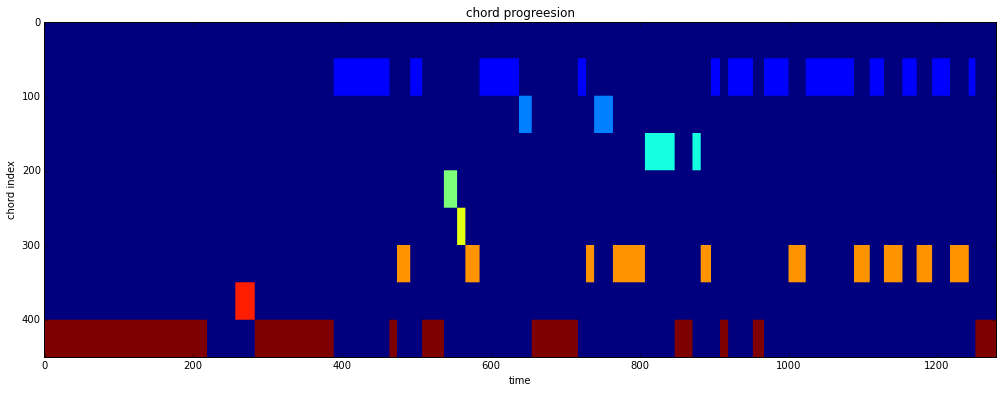

In [16]:
matplotlib.pylab.rcParams['figure.figsize'] = (18, 6)

# Detemine the size of the 2D matrix
end_time = chords[-1][1] # the end
chord_set = sorted(set([symbol for t0, t1, symbol in chords])) # Now we know how many unique chords were in this song

# construct the x-axis (time)
fps = 10 # frame per second 
t = range(int(end_time) * fps)

# scale the y-axis (chord index)
scale = 50

# make a map of symbol to index
symbol_to_index = {}
for index, c in enumerate(chord_set):
    symbol_to_index[c] = index
    
# fillin the blank into matrix
m = np.zeros((len(chord_set) * scale, len(t))) # matrix
for c in chords:
    t0, t1, symbol = c
    index = symbol_to_index[symbol]
    # the scale is just to widden the axis
    m[index*scale:(index+1)*scale, int(t0*fps):int(t1*fps)] = index # each index value will have differnt color.
   
# plot the visualization matrix 
plt.imshow(m)
plt.xlabel("time")
plt.ylabel("chord index")
plt.title("chord progreesion")


## Summary and reference
The tutorial high light the basic processing and some applications of MIR using the madmom library. If you are interseted in more details about the library and how these algorithm works. Here are some useful links:
1. Madmom library documentation : https://madmom.readthedocs.io/en/latest/index.html
2. MIREX (Music Information Retrieval Evaluation eXchange): http://www.music-ir.org/mirex/wiki/MIREX_HOME